**Build a Predictive Model:** Lets create a classification model to test if it's possible to accurately predict which stress a plant is experiencing based solely on its spectral data.  

In [1]:
# Lets import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import keras

# import the first sheet of the dataset
df1_0 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=0)
df1_1 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=1)
df1_2 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=2)
df1_3 = pd.read_excel("Datos1_InteraccionesNIR.xlsx", sheet_name=3)


# Concatenate all sheets into a single DataFrame
df1 = pd.concat([df1_0, df1_1, df1_2, df1_3], ignore_index=True)
df1.shape


(955, 2153)

In [2]:
#Let's separate the features and the target variable
X_features = df1.drop(columns=["Tratamiento", "Planta"])

y_target = df1["Tratamiento"]

print("features dataframe:")
X_features.head()

features dataframe:


,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.061030,0.060394,0.053344,0.054736,0.057163,0.055928,0.049880,0.043096,0.041127,0.044614,...,0.044963,0.044834,0.044802,0.044657,0.044370,0.044198,0.044046,0.043928,0.043878,0.043752
1,0.060823,0.060909,0.056016,0.056755,0.057975,0.056499,0.051715,0.047413,0.045700,0.046623,...,0.037656,0.037458,0.037266,0.037120,0.036929,0.036832,0.036861,0.036779,0.036661,0.036570
2,0.059742,0.060113,0.057320,0.059280,0.059741,0.057078,0.053557,0.049205,0.047486,0.048903,...,0.036252,0.036049,0.035732,0.035558,0.035431,0.035338,0.035368,0.035286,0.035157,0.035058
3,0.048861,0.047099,0.044486,0.049340,0.052701,0.050598,0.044007,0.038449,0.036496,0.038123,...,0.033894,0.033762,0.033693,0.033536,0.033412,0.033204,0.032831,0.032637,0.032501,0.032376
4,0.063155,0.060788,0.057388,0.058424,0.060128,0.059009,0.053017,0.048921,0.047316,0.048053,...,0.033897,0.033729,0.033675,0.033571,0.033515,0.033441,0.033317,0.033257,0.033285,0.033205


In [3]:
print("target variable:")
y_target.head()

num_classes = y_target.nunique()
print(f"Number of unique classes in target variable: {num_classes}")


target variable:
Number of unique classes in target variable: 8


In [4]:
# lets split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [5]:
# Get the validatiion set from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [6]:
# Encode the target variable

# Ordinal encoding of the target variable
encoder = OrdinalEncoder()
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
print("Encoded target variable:")
print(y_train_encoded[:5])

# Since model uses sparse_categorical_crossentropy loss, we keep the integer labels
# Just flatten the arrays for proper shape
y_train = y_train_encoded.flatten()
y_test = y_test_encoded.flatten()
y_val = y_val_encoded.flatten()

Encoded target variable:
[[0.]
 [5.]
 [4.]
 [0.]
 [3.]]


Let's make a 1 dimensional Convolutional Neural Network (1D CNN) using TensorFlow/Keras.

In [7]:
# Reshape the input data for Conv1D (samples, timestamps, features)
# We need to add an extra dimension to the data
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

# Define the input shape for our Conv1D model
input_shape = (X_train.shape[1], 1)  # (2151, 1)
print(f"Input shape: {input_shape}")


# Build the 1D CNN model
model = keras.Sequential([
    # Input layer
    keras.layers.Input(shape=input_shape),

    # First Conv1D block
    keras.layers.Conv1D(filters=32, kernel_size=15, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(pool_size=4),
    
    # Second Conv1D block
    keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu', padding='same'),  
    keras.layers.MaxPooling1D(pool_size=4),

    # Third Conv1D block
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),  
    keras.layers.MaxPooling1D(pool_size=4),


    # Flatten the output to feed into Dense layers
    keras.layers.Flatten(),
    
    # Dense hidden layer
    keras.layers.Dense(128, activation='relu'),  # Increased neurons
    
    # Dropout for regularization to prevent overfitting
    keras.layers.Dropout(0.5),
    
    # Output layer with softmax for multi-class classification
    keras.layers.Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

Input shape: (2151, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2151, 32)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 537, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 537, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 134, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 33, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4224)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       540,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,928 (2.30 MB)

 Trainable params: 601,928 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Define batch size and number of epochs
batch_size = 128 
epochs = 200
  

# early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.1266 - loss: 2.0820 - val_accuracy: 0.1299 - val_loss: 2.0790
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1368 - loss: 2.0788 - val_accuracy: 0.1299 - val_loss: 2.0774
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1208 - loss: 2.0789 - val_accuracy: 0.1299 - val_loss: 2.0778
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1310 - loss: 2.0790 - val_accuracy: 0.1558 - val_loss: 2.0779
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1237 - loss: 2.0780 - val_accuracy: 0.1688 - val_loss: 2.0757
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1339 - loss: 2.0773 - val_accuracy: 0.1688 - val_loss: 2.0726
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1485 - loss: 2.0747 - val_accuracy: 0.1948 - val_loss: 2.0695
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1456 - loss: 2.0769 - val_accuracy: 0.1299 - val_loss:

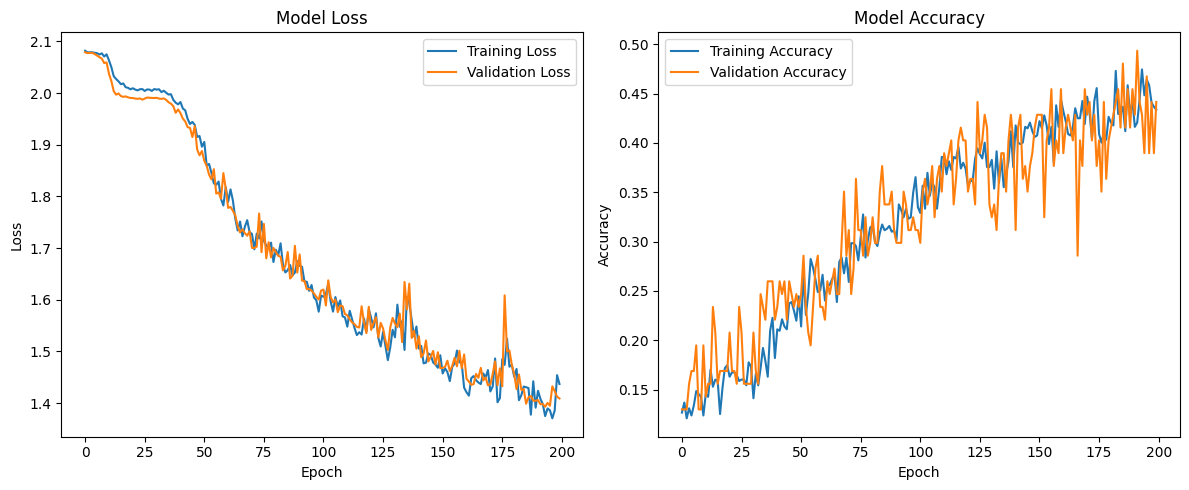

In [9]:
# Plot the training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Lets take a look at the test set performance
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4346 - loss: 1.4491 
Test Loss: 1.4491, Test Accuracy: 0.4346
